In [1]:
# Install Dependencies
import pandas as pd
import scipy.stats as stat
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Set Data Paths
mouse_metadata_path = '../data/Mouse_metadata.csv'
study_results_path = '../data/study_results.csv'

# Load Data Into Pandas
mouse_metadata_df = pd.read_csv(mouse_metadata_path)
study_results_df = pd.read_csv(study_results_path)

study_data_df = pd.merge(study_results_df, mouse_metadata_df, how='left', on='Mouse ID')

study_data_df.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.0,0,Capomulin,Female,9,22
1,f932,0,45.0,0,Ketapril,Male,15,29
2,g107,0,45.0,0,Ketapril,Female,2,29
3,a457,0,45.0,0,Ketapril,Female,11,30
4,c819,0,45.0,0,Ketapril,Male,21,25


In [2]:
# Get duplicate values from study data
duplicate_mouse_row = study_data_df.duplicated(subset=['Mouse ID', 'Timepoint'])
duplicate_mouse_df = study_data_df[duplicate_mouse_row]
duplicate_mouse_id_list = duplicate_mouse_df['Mouse ID'].unique()

# Drop all mice that have duplicate study rows
study_data_df = study_data_df[~study_data_df['Mouse ID'].isin(duplicate_mouse_id_list)]

## Summary Statistics

In [23]:
# Get summary statistics
drug_summary_df = study_data_df.groupby('Drug Regimen')['Tumor Volume (mm3)'].agg(
    Mean_Tumor_Volume = np.mean,
    Median_Tumor_Volume = np.median,
    Variance_Tumor_Volume = np.var,
    Stdev_Tumor_Volume = np.std,
    SEM_Tumor_Voume = stat.sem
)

# Rename columns
drug_summary_df.rename(columns={
    'Mean_Tumor_Volume': 'Mean Tumor Volume',
    'Median_Tumor_Volume': 'Median Tumor Volume',
    'Variance_Tumor_Volume': 'Tumor Volume Variance',
    'Stdev_Tumor_Volume': 'Tumor Volume Stdev',
    'SEM_Tumor_Volume': 'Tumor Volume SEM'
}, inplace = True)

drug_summary_df

,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Variance,Tumor Volume Stdev,SEM_Tumor_Voume
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


## Bar and Pie Charts

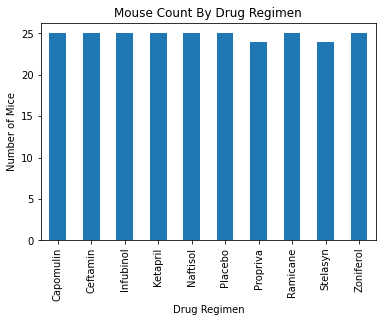

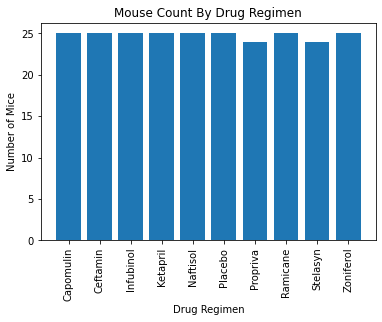

In [36]:
mice_per_trial = study_data_df.groupby('Drug Regimen')['Mouse ID'].nunique()

#plot using pandas
mice_per_trial.plot(kind='bar', rot=90, title='Mouse Count By Drug Regimen')
plt.xlabel('Drug Regimen')
plt.ylabel('Number of Mice')
plt.show()

# plot using matplotlib
plt.bar(mice_per_trial.index, mice_per_trial)
plt.xlabel('Drug Regimen')
plt.ylabel('Number of Mice')
plt.title('Mouse Count By Drug Regimen')
plt.xticks(rotation=90)
plt.show()

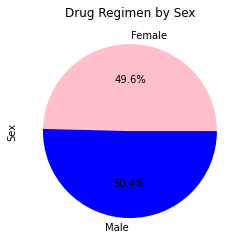

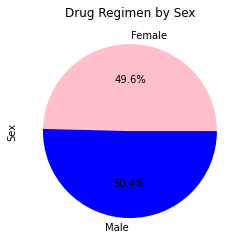

In [43]:
mice_gender = study_data_df.groupby('Sex')['Mouse ID'].nunique()

# plot using pandas
mice_gender.plot(kind = 'pie', title='Drug Regimen by Sex', autopct='%1.1f%%', colors=['pink', 'blue'])
plt.ylabel('Sex')
plt.show()

# plot using matplotlib
plt.pie(mice_gender, labels=['Female', 'Male'], autopct='%1.1f%%', colors=['pink', 'blue'])
plt.title('Drug Regimen by Sex')
plt.ylabel('Sex')
plt.show()

## Quartiles, Outliers, and Boxplots

In [56]:
filtered_drugs_df = study_data_df[study_data_df['Drug Regimen'].isin(['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin'])]

last_timepoint = filtered_drugs_df.groupby('Mouse ID')['Timepoint'].max()

filtered_drugs_df = filtered_drugs_df.merge(last_timepoint, how='inner', on=['Mouse ID', 'Timepoint'])
filtered_drugs_df.set_index('Mouse ID', inplace=True)
filtered_drugs_df

,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
Mouse ID,,,,,,,
u153,0,45.000000,0,Ceftamin,Female,11,25
b447,0,45.000000,0,Ceftamin,Male,2,30
x226,0,45.000000,0,Ceftamin,Male,23,28
t573,0,45.000000,0,Ceftamin,Female,15,27
c326,5,36.321346,0,Infubinol,Female,18,25
...,...,...,...,...,...,...,...
a644,45,32.978522,1,Ramicane,Female,7,17
i177,45,33.562402,3,Ramicane,Male,10,18
r944,45,41.581521,2,Capomulin,Male,12,25


In [141]:
drug_list = filtered_drugs_df['Drug Regimen'].unique()
plot_list = {}

for drug in drug_list:
    drug_df = filtered_drugs_df.loc[filtered_drugs_df['Drug Regimen'] == drug][['Drug Regimen', 'Tumor Volume (mm3)']]
    plot_list[drug] = (drug_df['Tumor Volume (mm3)'].to_list())
    quartiles = drug_df['Tumor Volume (mm3)'].quantile([.25, .50, .75])

    lower_q = quartiles[0.25]
    upper_q = quartiles[0.75]
    iqr = upper_q - lower_q
    median = quartiles[0.50]

    lower_bound = lower_q - (1.5 * iqr)
    upper_bound = upper_q + (1.5 * iqr)

    print(f'{drug} Stats:')
    print(f'The lower quartile of Tumor Volume is {lower_q:.3f} mm3')
    print(f'The upper quartile of Tumor Volume is {upper_q:.3f} mm3')
    print(f'The inter quartile range of Tumor Volume is {iqr:.3f} mm3')
    print(f'The median of tumor volume is {median:.3f} mm3')
    print(f'Tumor Volumes below {lower_bound:.3f} mm3 could be outliers')
    print(f'Tumor Volumes above {upper_bound:.3f} mm3 could be outliers \n')

Ceftamin Stats:
The lower quartile of Tumor Volume is 48.722 mm3
The upper quartile of Tumor Volume is 64.300 mm3
The inter quartile range of Tumor Volume is 15.578 mm3
The median of tumor volume is 59.852 mm3
Tumor Volumes below 25.355 mm3 could be outliers
Tumor Volumes above 87.666 mm3 could be outliers 

Infubinol Stats:
The lower quartile of Tumor Volume is 54.049 mm3
The upper quartile of Tumor Volume is 65.526 mm3
The inter quartile range of Tumor Volume is 11.477 mm3
The median of tumor volume is 60.165 mm3
Tumor Volumes below 36.833 mm3 could be outliers
Tumor Volumes above 82.741 mm3 could be outliers 

Ramicane Stats:
The lower quartile of Tumor Volume is 31.560 mm3
The upper quartile of Tumor Volume is 40.659 mm3
The inter quartile range of Tumor Volume is 9.099 mm3
The median of tumor volume is 36.562 mm3
Tumor Volumes below 17.913 mm3 could be outliers
Tumor Volumes above 54.307 mm3 could be outliers 

Capomulin Stats:
The lower quartile of Tumor Volume is 32.377 mm3
The 

<ipython-input-150-36682e822c5b>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(plot_list.keys())


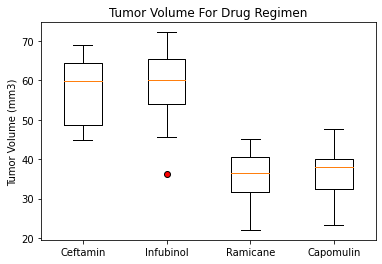

In [150]:
outlier_marker ={'markerfacecolor':'r', 'marker':'o'}

fig, ax = plt.subplots()
ax.set_title('Tumor Volume For Drug Regimen')
ax.set_xticklabels(plot_list.keys())
ax.set_ylabel('Tumor Volume (mm3)')
ax.boxplot(plot_list.values(), flierprops=outlier_marker)
plt.show()

## Line and Scatter Plots

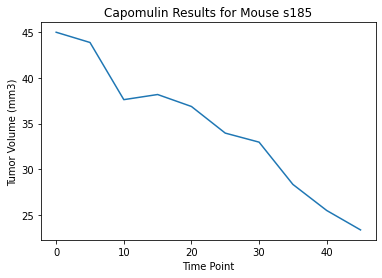

In [153]:
s185_df = study_data_df.loc[study_data_df['Mouse ID'] == 's185']

tumor_volume = s185_df['Tumor Volume (mm3)']
time_point = s185_df['Timepoint']

plt.plot(time_point, tumor_volume)
plt.title('Capomulin Results for Mouse s185')
plt.xlabel('Time Point')
plt.ylabel('Tumor Volume (mm3)')
plt.show()